# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Problemdefinition und Ziele

## 🧩 **„Welche Arten von Unternehmensstandorten gibt es in Berlin und wie unterscheiden sie sich hinsichtlich Bevölkerungstruktur und Wirtschaftszweig?“**


### 🔍 **Was bedeutet das konkret?**

Durch **Clustering** gruppierst du ähnliche Unternehmensstandorte in Berlin anhand von:

- **Unternehmenstyp** (z.B. Größe, Branche, Unternehmensalter)
- **Sozialstruktur der Nachbarschaft** (Bodenrichtwert, Einwohnerzahl, Alter der Einwohner, Einwohnerdichte)
- **Räumliche Faktoren** (Bezirk, Typ der Fläche)


### 📌 **Warum könnte dies relevant sein?**

- Du identifizierst **typische Standortprofile**:  
  z.B. „Gewerbestandorte mit älterer Bevölkerung und niedrigem Bodenrichtwert“ vs. „Innovative Standorte mit jungen Menschen und hohen Immobilienwerten“.

- Die Ergebnisse können der IHK oder Stadtplanern helfen, zu verstehen, **welche Art von Unternehmen sich wo ansiedeln** und warum, sowie welche Faktoren eine Standortwahl beeinflussen.

- Daraus könnten gezielte **Standortförderungen** oder Stadtentwicklungsmaßnahmen abgeleitet werden.


### 🛠️ **Wie könnte man das methodisch umsetzen?**

- **Feature-Auswahl**:
  - `Bodenrichtwert`, `business_age`
  - Demografische Merkmale: `ew2023`, `ew_ha_2023`
  - Wirtschaftszweige: `Branche_grob`
  - Räumliche Merkmale: `Bezirk`

- **Clustering-Verfahren**:
  - KMeans, DBSCAN oder hierarchisches Clustering
  - Nach Clusterbildung: Interpretation der Cluster (z.B. Visualisierung mit Geo-Karten)


### 🎯 **Typische Fragestellungen, die sich daraus ableiten:**

- Welche Standorttypen ziehen junge oder innovative Unternehmen an?
- Gibt es klar definierte Cluster mit ähnlicher Altersstruktur oder wirtschaftlichen Aktivitäten?
- Welche Standorttypen haben hohen Bodenrichtwert und welche Faktoren begünstigen diesen?


### 🚩 **Beispiel einer konkreten Problemfrage:**

> **„Welche Standorttypen von Unternehmen existieren in Berlin, und welche sozioökonomischen und demografischen Faktoren charakterisieren diese Standorttypen besonders?“**


### 📊 **Nutzen des Ergebnisses:**

Die Cluster-Ergebnisse ermöglichen eine zielgerichtete **Standortplanung**, **gezielte Förderpolitik** sowie ein verbessertes Verständnis der **lokalen Wirtschaftsstruktur** Berlins.


Diese Problemstellung eignet sich hervorragend, um die Daten mittels Clustering sinnvoll zu analysieren und strategisch wertvolle Erkenntnisse zu gewinnen!

In [2]:
df = pd.read_csv("../input/ihk_gewerbedaten_with_brw_einwohnerdichte.csv.gz",
                 compression="gzip",
                 header=0,
                 sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336180 entries, 0 to 336179
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          336180 non-null  int64  
 1   city                 336180 non-null  object 
 2   postcode             336180 non-null  int64  
 3   latitude             336180 non-null  float64
 4   longitude            336180 non-null  float64
 5   ihk_branch_id        336180 non-null  float64
 6   employees_range      336180 non-null  object 
 7   ihk_branch_desc      336180 non-null  object 
 8   business_age         336180 non-null  float64
 9   business_type        336180 non-null  object 
 10  Bezirk               336180 non-null  object 
 11  planungsraum_id      336180 non-null  float64
 12  Planungsraum         336180 non-null  object 
 13  Bezirksregion        336180 non-null  object 
 14  Prognoseraum         336180 non-null  object 
 15  Ortsteil         

# EDA (Understanding & Preperation)

| Column        | Description |
| ------------- | ------------- |
| opendata_id           | Primary key |
| city                  | City of the business |
| postcode              | Postcode of the business |
| latitude              | Geolocation of the business, described by the latitude (Format: EPSG 4326) |
| longitude             | Geolocation of the business, described by the longitude (Format: EPSG 4326) |
| ihk_branch_id         | Branch ID of the business as defined by IHK classification of economic activities (finest granuality of distinction), see [IHK Wirtschaftszweige](https://www.ihk.de/blueprint/servlet/resource/blob/5186288/c8bb510197a45c71b59b7a27cdc31bcb/wzbra-wahlgruppen-fit-data.pdf) |
| employees_range       | The reported number of employees as range  |
| ihk_branch_desc       | Branch description of the business as defined by IHK classification of economic activities|
| business_age          | Current age of the business |
| business_type         | "Kleingewerbetreibender" = the business is a small trader, "im Handelsregister eingetragen" = the business is registered in the Commercial Register  |
| Bezirk                | Bezirk of the business |
| planungsraum_id       | LOR Planungsraum ID |
| Planungsraum          | LOR Planungsraum |
| Bezirksregion         | LOR Bezirksregion |
| Prognoseraum          | LOR Prognoseraum  |
| Ortsteil              | Ortsteil of the business |
|employees_numerical    | Der Durchschnitt aus den 2 Grenzen von employees_range |
|gründungsjahr          | Das Gründungsjahr berechnet von letztem Commit (Datum) an der CSV Datei von der IHK subtrahiert mit dem business_age |
|Bodenrichtwert         | Der Bodenrichtwert vom Stand 01.01.2024 |
|ew2023                 | Anzahl Einwohner > 2 vom Stand 01.01.2023 im Viertel|
|flalle                 | Flächengröße [m²] vom Stand 01.01.2023 im Viertel|
|ha                     | Flächengröße der ISU5-Fläche vom Stand 01.01.2023 im Viertel|
|ew_ha_2023             | Einwohner pro Hektar vom Stand 01.01.2023 im Viertel|
|alter_u6               | Anzahl der Einwohner (> 2), die jünger als 6 Jahre sind vom Stand 01.01.2023 im Viertel|
| alter_6_u10           | Anzahl der Einwohner (> 2), die 6 bis unter 10 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_10_u18          | Anzahl der Einwohner (> 2), die 10 bis unter 18 Jahre alt sind vom Stand 01.01.2023  im Viertel|
| alter_18_u65          | Anzahl der Einwohner (> 2), die 18 bis unter 65 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_65_u70          | Anzahl der Einwohner (> 2), die 65 bis unter 70 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_70_u75          | Anzahl der Einwohner (> 2), die 70 bis unter 75 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter75_u80           | Anzahl der Einwohner (> 2), die 75 bis unter 80 Jahre alt sind vom Stand 01.01.2023 im Viertel|
| alter_80plus          | Anzahl der Einwohner (> 2), die 80 Jahre alt oder älter sind vom Stand 01.01.2023 im Viertel|
| typklar               | Es werden 52 verschiedene Flächentypen unterschieden. Im Gegensatz zu den Nutzungen GRZ und WOZ wird hier besonders Wert auf eine differenzierte Darstellung der baulichen Nutzungen gelegt, die stadtstrukturell (Siedlungstyp, Alter etc.)  unterschieden werden. Die Flächentypen werden auch zur Zuordnung weitererer Indikatoren verwendet (Belagsklassen der Versiegelung, Kanalisation) |

In [3]:
df.head()

,opendata_id,city,postcode,latitude,longitude,ihk_branch_id,employees_range,ihk_branch_desc,business_age,business_type,...,ew_ha_2023,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus,typklar
0,572114,Berlin,10179,52.513315,13.411584,65122.0,0 Beschäftigte,Schaden- u. Unfallversicherungen,40.0,Kleingewerbetreibender,...,60.68,0.0,0.0,12.0,22.0,0.0,0.0,13.0,0.0,Kerngebiet
1,131831318,Berlin,10713,52.479296,13.319051,47430.0,0 Beschäftigte,EH m. Geräten der Unterhaltungselektronik,40.0,Kleingewerbetreibender,...,487.59,59.0,33.0,63.0,668.0,40.0,27.0,34.0,43.0,"Geschlossene Blockbebauung, Hinterhof (1870er ..."
2,943032071440,Berlin,12047,52.486200,13.429312,731108.0,0 Beschäftigte,"Promotion, Propagandisten",13.0,im Handelsregister eingetragen,...,666.12,18.0,3.0,22.0,202.0,3.0,0.0,3.0,3.0,"Geschlossene Blockbebauung, Hinterhof (1870er ..."
3,927441671472,Berlin,10117,52.513509,13.385791,6831.0,4 - 6 Beschäftigte,"Vermittlung v. Grundstücken, Gebäuden u. Wohnu...",10.0,Kleingewerbetreibender,...,101.53,3.0,0.0,3.0,37.0,3.0,3.0,0.0,0.0,Kerngebiet
4,942996071320,Berlin,10245,52.513798,13.454217,62020.0,0 Beschäftigte,Erbringung v. Beratungsleistungen auf dem Gebi...,10.0,im Handelsregister eingetragen,...,344.41,88.0,41.0,57.0,1157.0,16.0,10.0,6.0,13.0,"Geschlossene Blockbebauung, Hinterhof (1870er ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336180 entries, 0 to 336179
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          336180 non-null  int64  
 1   city                 336180 non-null  object 
 2   postcode             336180 non-null  int64  
 3   latitude             336180 non-null  float64
 4   longitude            336180 non-null  float64
 5   ihk_branch_id        336180 non-null  float64
 6   employees_range      336180 non-null  object 
 7   ihk_branch_desc      336180 non-null  object 
 8   business_age         336180 non-null  float64
 9   business_type        336180 non-null  object 
 10  Bezirk               336180 non-null  object 
 11  planungsraum_id      336180 non-null  float64
 12  Planungsraum         336180 non-null  object 
 13  Bezirksregion        336180 non-null  object 
 14  Prognoseraum         336180 non-null  object 
 15  Ortsteil         

In [5]:
df.describe()

,opendata_id,postcode,latitude,longitude,ihk_branch_id,business_age,planungsraum_id,employees_numerical,gründungsjahr,Bodenrichtwert,...,ha,ew_ha_2023,alter_u6,alter_6_u10,alter_10_u18,alter_18_u65,alter_65_u70,alter_70_u75,alter75_u80,alter_80plus
count,3.361800e+05,336180.000000,336180.000000,336180.000000,3.361800e+05,336180.000000,3.361800e+05,336180.000000,336180.000000,336180.000000,...,336180.000000,336180.000000,336180.000000,336180.000000,336180.000000,336180.000000,336180.000000,336180.000000,336180.000000,336180.000000
mean,7.388164e+11,11830.460054,52.505327,13.385594,8.956494e+05,9.382628,5.558229e+06,4.230252,2015.617372,3065.466460,...,3.206253,249.176705,31.760839,21.041457,38.210021,396.325311,23.511878,20.289262,14.961262,25.393099
std,2.820992e+12,1330.735172,0.045934,0.092684,2.037052e+06,9.605879,3.340568e+06,83.367534,9.605879,3408.431222,...,4.087950,181.169186,35.626643,25.895971,47.938997,366.619600,26.404323,24.778379,19.804239,39.083397
min,5.721140e+05,10115.000000,52.340481,13.096560,0.000000e+00,0.000000,1.100101e+06,0.000000,1925.000000,0.600000,...,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.056209e+11,10587.000000,52.479203,13.323861,5.911000e+04,2.000000,2.500834e+06,0.000000,2011.000000,700.000000,...,1.410000,80.150000,9.000000,6.000000,9.000000,112.000000,6.000000,6.000000,3.000000,6.000000
50%,1.917686e+11,12055.000000,52.506552,13.386418,8.810200e+04,7.000000,4.501045e+06,0.000000,2018.000000,2100.000000,...,2.260000,238.950000,23.000000,15.000000,26.000000,307.000000,18.000000,13.000000,9.000000,15.000000
75%,1.125918e+12,13088.000000,52.534013,13.435754,7.022000e+05,14.000000,8.100207e+06,2.000000,2023.000000,4500.000000,...,3.460000,378.200000,45.000000,28.000000,51.000000,579.000000,32.000000,27.000000,19.000000,30.000000
max,6.816592e+13,14199.000000,52.660085,13.741143,9.609094e+06,100.000000,1.260124e+07,12500.000000,2025.000000,60000.000000,...,125.580000,1153.060000,424.000000,370.000000,837.000000,3176.000000,320.000000,340.000000,300.000000,593.000000


## Branchen (grob) erstellen

In [6]:
dic_wz = {
    "LAND- UND FORSTWIRTSCHAFT, FISCHEREI" : [1, 3],
    "ABERGBAU UND GEWINNUNG VON STEINEN UND ERDEN" : [5, 9],
    "VERARBEITENDES GEWERBE" : [10, 33],
    "ENERGIEVERSORGUNG" : [35, 35],
    "WASSERVERSORGUNG; ABWASSER- UND ABFALLENTSORGUNG UND BESEITIGUNG VON UMWELTVERSCHMUTZUNGEN" : [36, 39],
    "BAUGEWERBE" : [41, 43],
    "HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFTFAHRZEUGEN" : [45, 47],
    "VERKEHR UND LAGEREI" : [49, 53],
    "GASTGEWERBE" : [55, 56],
    "INFORMATION UND KOMMUNIKATION" : [58, 63],
    "ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEISTUNGEN" : [64, 66],
    "GRUNDSTÜCKS- UND WOHNUNGSWESEN" : [68, 68],
    "ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN" : [69, 75],
    "ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN" : [77, 82],
    "ÖFFENTLICHE VERWALTUNG, VERTEIDIGUNG; SOZIALVERSICHERUNG" : [84, 84],
    "ERZIEHUNG UND UNTERRICHT" : [85, 85],
    "GESUNDHEITS- UND SOZIALWESEN" : [86, 88],
    "KUNST, UNTERHALTUNG UND ERHOLUNG" : [90, 93],
    "ERBRINGUNG VON SONSTIGEN DIENSTLEISTUNGEN" : [94, 96],
    "PRIVATE HAUSHALTE MIT HAUSPERSONAL; HERSTELLUNG VON WAREN UND ERBRINGUNG VON DIENSTLEISTUNGEN DURCH PRIVATE HAUSHALTE FÜR DEN EIGENBEDARF OHNE AUSGEPRÄGTEN SCHWERPUNKT" : [97, 98],
    "EXTERRITORIALE ORGANISATIONEN UND KÖRPERSCHAFTEN" : [99, 99]
}

In [7]:
def get_branche_grob(ihk_branch_id):
    if pd.isnull(ihk_branch_id):
        return np.nan
    
    ihk_id_int = int(str(int(ihk_branch_id))[:2])
    
    for branche, (low, high) in dic_wz.items():
        if low <= ihk_id_int <= high:
            return branche
    return np.nan

In [8]:
df["Branche_grob"] = df["ihk_branch_id"].apply(get_branche_grob)
df[["ihk_branch_id", "Branche_grob"]].head()

,ihk_branch_id,Branche_grob
0,65122.0,ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENST...
1,47430.0,HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFT...
2,731108.0,"ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLI..."
3,6831.0,GRUNDSTÜCKS- UND WOHNUNGSWESEN
4,62020.0,INFORMATION UND KOMMUNIKATION


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336180 entries, 0 to 336179
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          336180 non-null  int64  
 1   city                 336180 non-null  object 
 2   postcode             336180 non-null  int64  
 3   latitude             336180 non-null  float64
 4   longitude            336180 non-null  float64
 5   ihk_branch_id        336180 non-null  float64
 6   employees_range      336180 non-null  object 
 7   ihk_branch_desc      336180 non-null  object 
 8   business_age         336180 non-null  float64
 9   business_type        336180 non-null  object 
 10  Bezirk               336180 non-null  object 
 11  planungsraum_id      336180 non-null  float64
 12  Planungsraum         336180 non-null  object 
 13  Bezirksregion        336180 non-null  object 
 14  Prognoseraum         336180 non-null  object 
 15  Ortsteil         

In [10]:
df[df["Branche_grob"].isna()]["ihk_branch_id"].value_counts()

ihk_branch_id
0.0        211
8990.0       5
89200.0      1
8910.0       1
Name: count, dtype: int64

0 = ist keine Branche

89 = existiert nicht

In [11]:
df.dropna(subset=["Branche_grob"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335962 entries, 0 to 336179
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          335962 non-null  int64  
 1   city                 335962 non-null  object 
 2   postcode             335962 non-null  int64  
 3   latitude             335962 non-null  float64
 4   longitude            335962 non-null  float64
 5   ihk_branch_id        335962 non-null  float64
 6   employees_range      335962 non-null  object 
 7   ihk_branch_desc      335962 non-null  object 
 8   business_age         335962 non-null  float64
 9   business_type        335962 non-null  object 
 10  Bezirk               335962 non-null  object 
 11  planungsraum_id      335962 non-null  float64
 12  Planungsraum         335962 non-null  object 
 13  Bezirksregion        335962 non-null  object 
 14  Prognoseraum         335962 non-null  object 
 15  Ortsteil             3

## employees_range

In [12]:
df["employees_range"].value_counts()

employees_range
0 Beschäftigte                 227715
1 - 3 Beschäftigte              75680
4 - 6 Beschäftigte              12086
10 - 19 Beschäftigte             7290
7 - 9 Beschäftigte               5186
20 - 49 Beschäftigte             4838
50 - 99 Beschäftigte             1612
100 - 199 Beschäftigte            841
200 - 499 Beschäftigte            456
500 - 999 Beschäftigte            134
1000 - 2499 Beschäftigte           86
2500 - 4999 Beschäftigte           20
5000 - 7499 Beschäftigte            6
10000 und mehr Beschäftigte         6
7500 - 9999 Beschäftigte            6
Name: count, dtype: int64

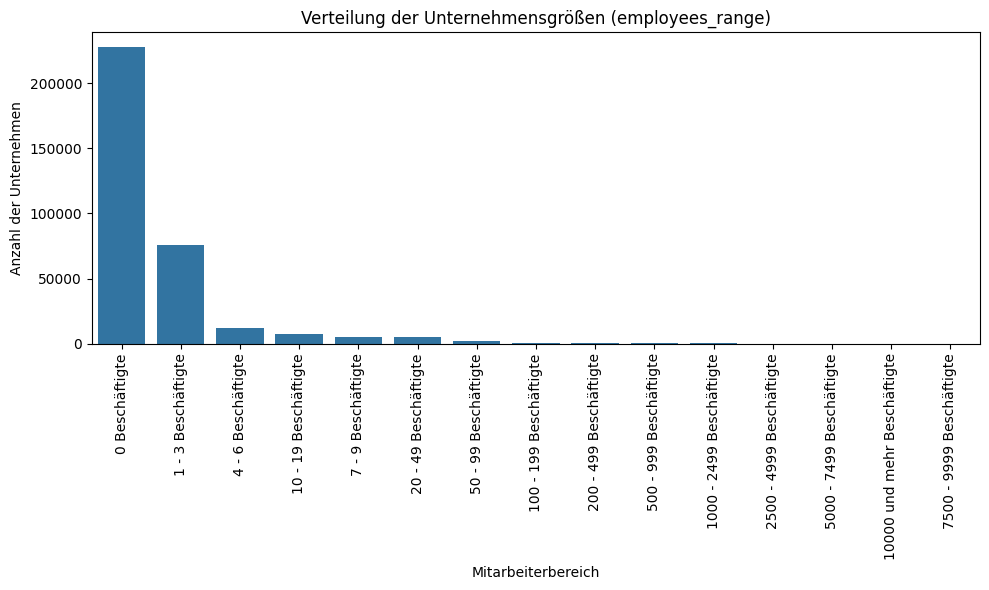

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["employees_range"].value_counts().index, y=df["employees_range"].value_counts().values)
plt.title("Verteilung der Unternehmensgrößen (employees_range)")
plt.xlabel("Mitarbeiterbereich")
plt.ylabel("Anzahl der Unternehmen")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Extrem unausgewogene Verteilung

68 % aller Einträge haben „0 Beschäftigte“, nur wenige Tausend haben >50 Beschäftigte.
Die kleinen Gruppen sind massiv unterrepräsentiert → Clusterung wird dominiert von Kleinstunternehmen.

## business_age

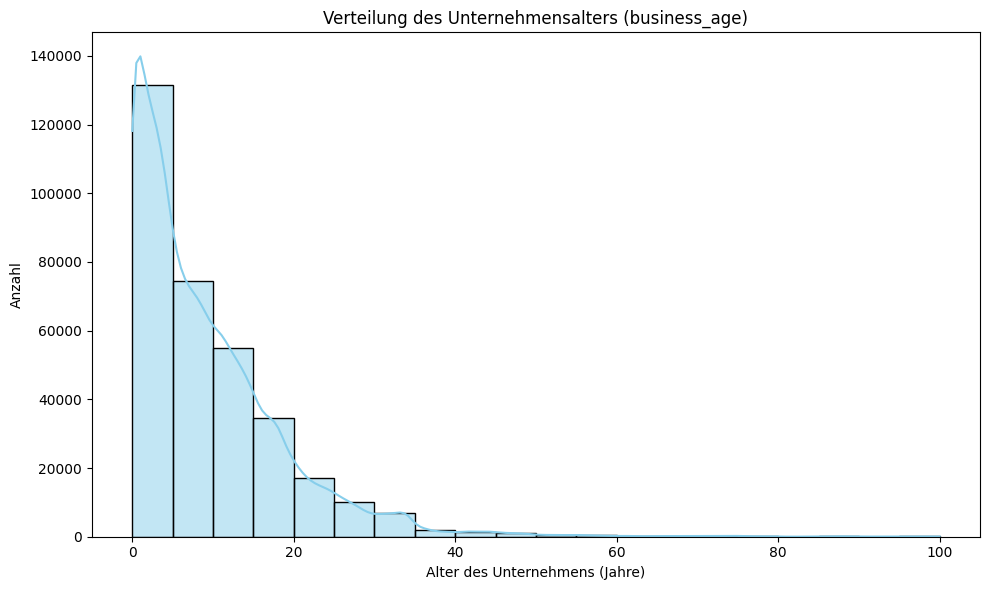

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['business_age'], bins=20, kde=True, color='skyblue')
plt.title("Verteilung des Unternehmensalters (business_age)")
plt.xlabel("Alter des Unternehmens (Jahre)")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

In [15]:
print(f"Unternehmen mit < 6 Jahren: {(df['business_age'] < 6).sum()}")
print(f"Unternehmen mit > 6 Jahren: {(df['business_age'] > 6).sum()}")

Unternehmen mit < 6 Jahren: 149048
Unternehmen mit > 6 Jahren: 171555


## Bezirke

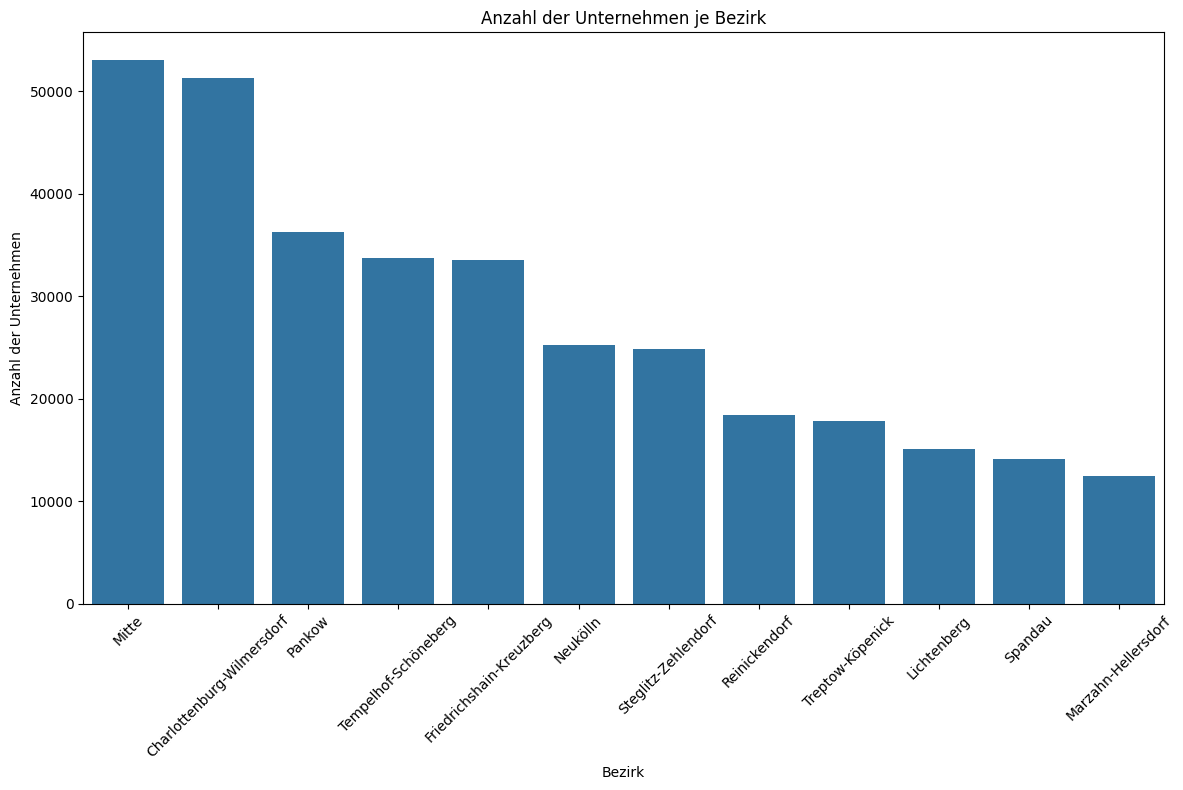

In [16]:
plt.figure(figsize=(12, 8))
sns.barplot(x=df["Bezirk"].value_counts().index, y=df["Bezirk"].value_counts().values)
plt.title("Anzahl der Unternehmen je Bezirk")
plt.xlabel("Bezirk")
plt.ylabel("Anzahl der Unternehmen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## employees_numerical

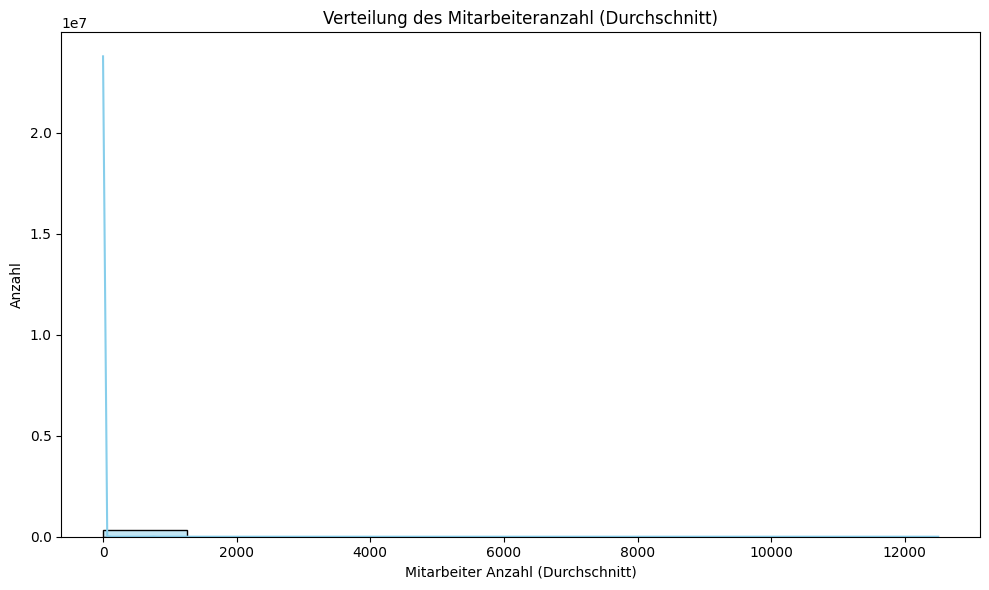

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['employees_numerical'], bins=10, kde=True, color='skyblue')
plt.title("Verteilung des Mitarbeiteranzahl (Durchschnitt)")
plt.xlabel("Mitarbeiter Anzahl (Durchschnitt)")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

Auch hier die Mitarbeiteranzahl sind zu stark gewichtet auf 0 - würde das Clustering benachteiligen

## gründungsjahr

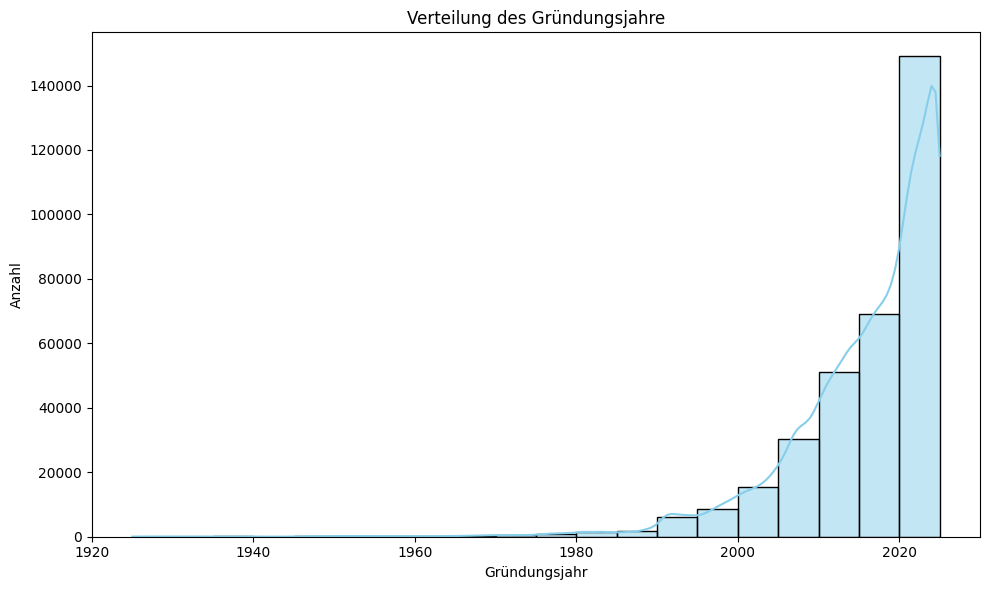

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df['gründungsjahr'], bins=20, kde=True, color='skyblue')
plt.title("Verteilung des Gründungsjahre")
plt.xlabel("Gründungsjahr")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

## Bodenrichtwert

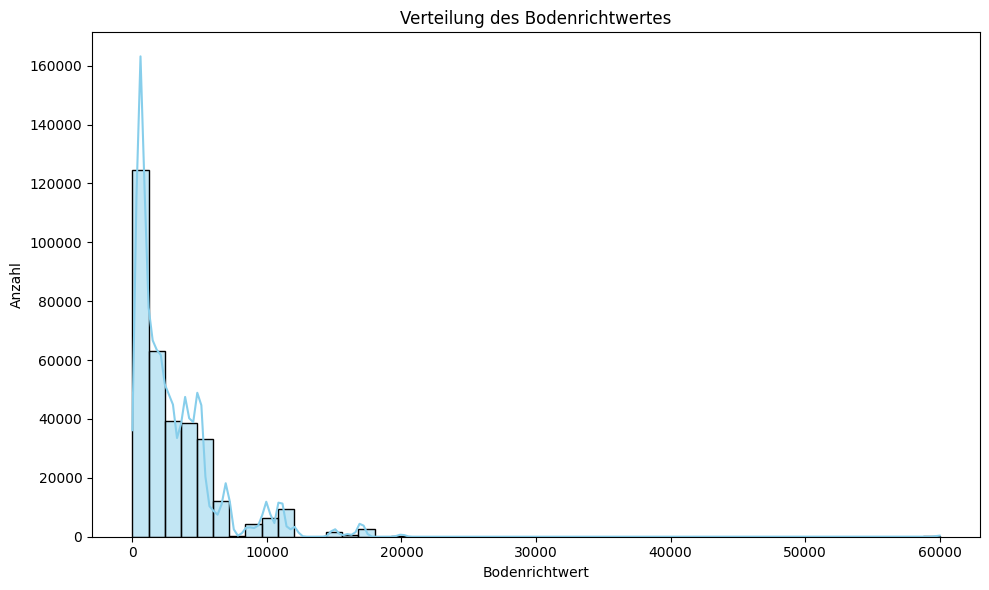

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Bodenrichtwert'], bins=50, kde=True, color='skyblue')
plt.title("Verteilung des Bodenrichtwertes")
plt.xlabel("Bodenrichtwert")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

In [20]:
df["Bodenrichtwert"].describe()

count    335962.000000
mean       3065.362017
std        3408.441098
min           0.600000
25%         700.000000
50%        2100.000000
75%        4500.000000
max       60000.000000
Name: Bodenrichtwert, dtype: float64

## ew2023

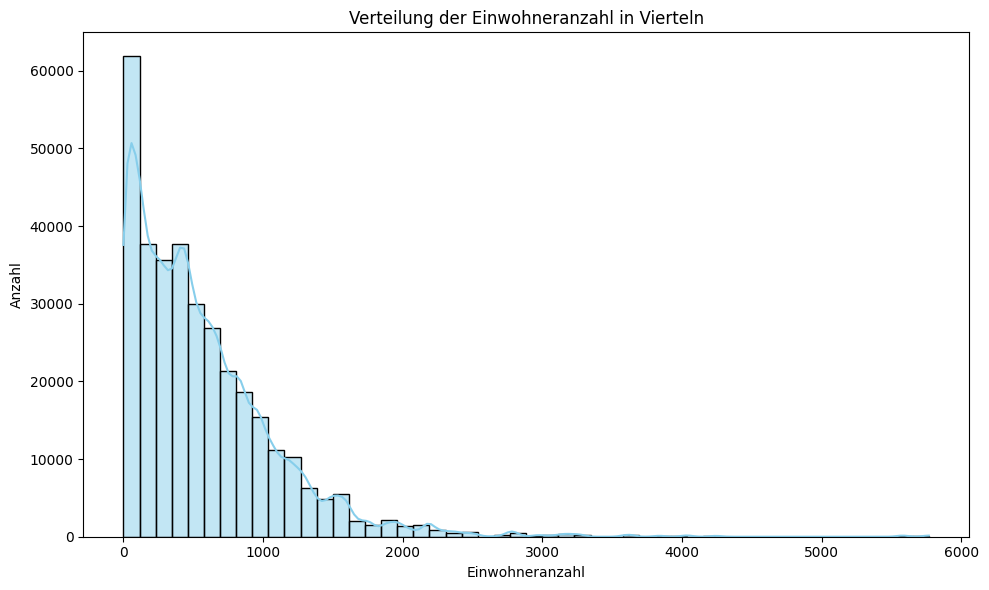

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ew2023'], bins=50, kde=True, color='skyblue')
plt.title("Verteilung der Einwohneranzahl in Vierteln")
plt.xlabel("Einwohneranzahl")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

In [22]:
df["ew2023"].describe()

count    335962.000000
mean        571.440267
std         534.135056
min           0.000000
25%         177.000000
50%         446.000000
75%         814.000000
max        5766.000000
Name: ew2023, dtype: float64

## ew_ha_2023

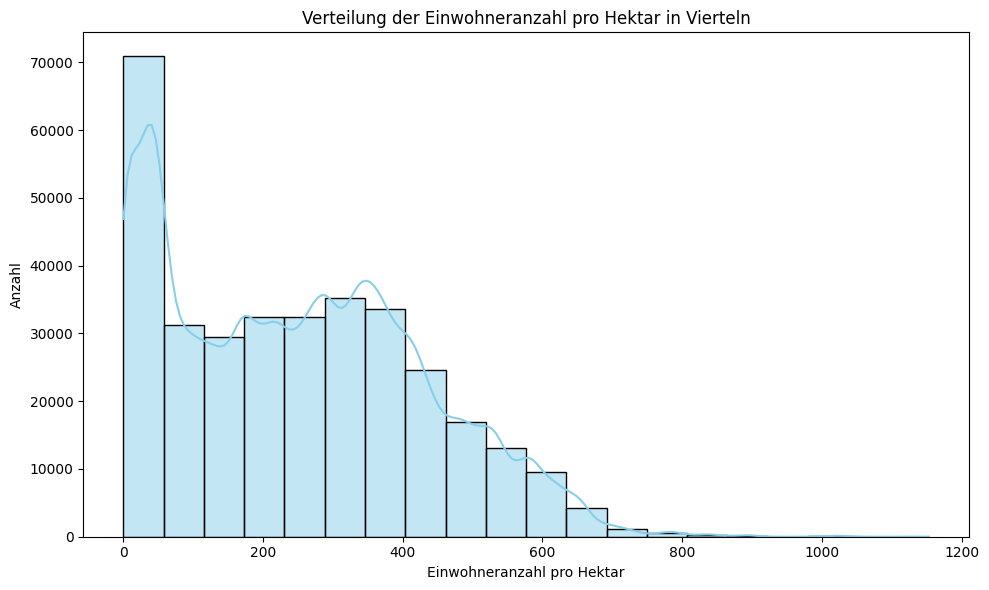

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ew_ha_2023'], bins=20, kde=True, color='skyblue')
plt.title("Verteilung der Einwohneranzahl pro Hektar in Vierteln")
plt.xlabel("Einwohneranzahl pro Hektar")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

In [24]:
df["ew_ha_2023"].describe()

count    335962.000000
mean        249.143146
std         181.164609
min           0.000000
25%          80.150000
50%         238.900000
75%         378.200000
max        1153.060000
Name: ew_ha_2023, dtype: float64

## typklar

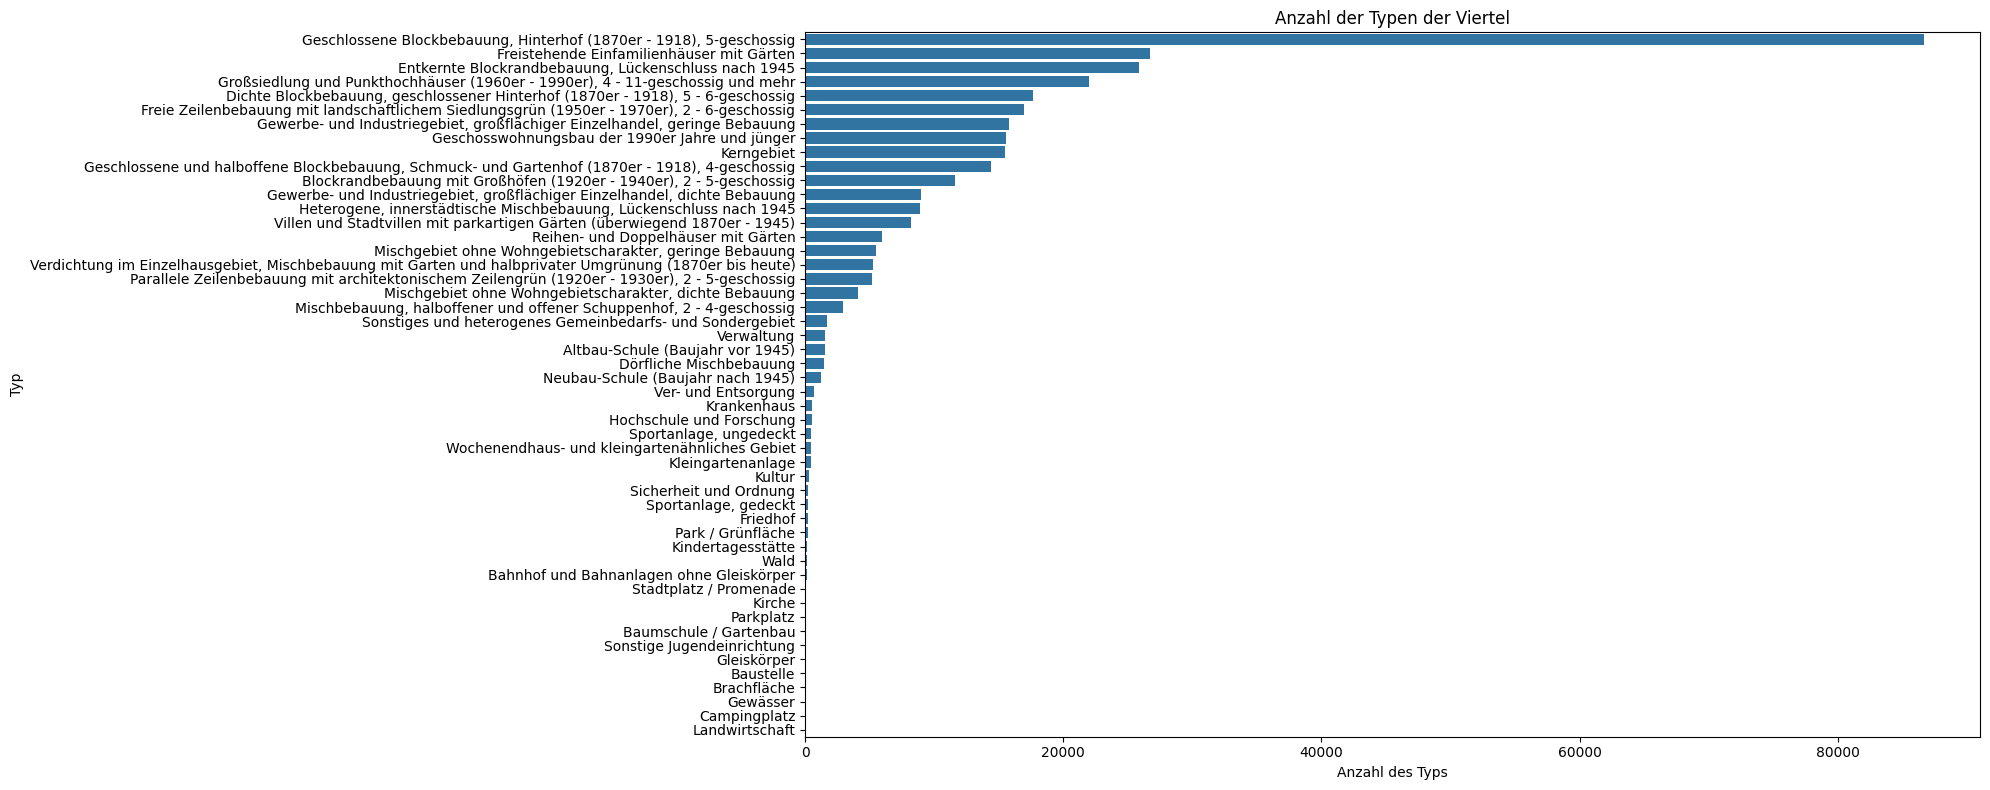

In [25]:
plt.figure(figsize=(20, 8))
sns.barplot(y=df["typklar"].value_counts().index, x=df["typklar"].value_counts().values)
plt.title("Anzahl der Typen der Viertel")
plt.ylabel("Typ")
plt.xlabel("Anzahl des Typs")
plt.tight_layout()
plt.show()

## Branche_grob

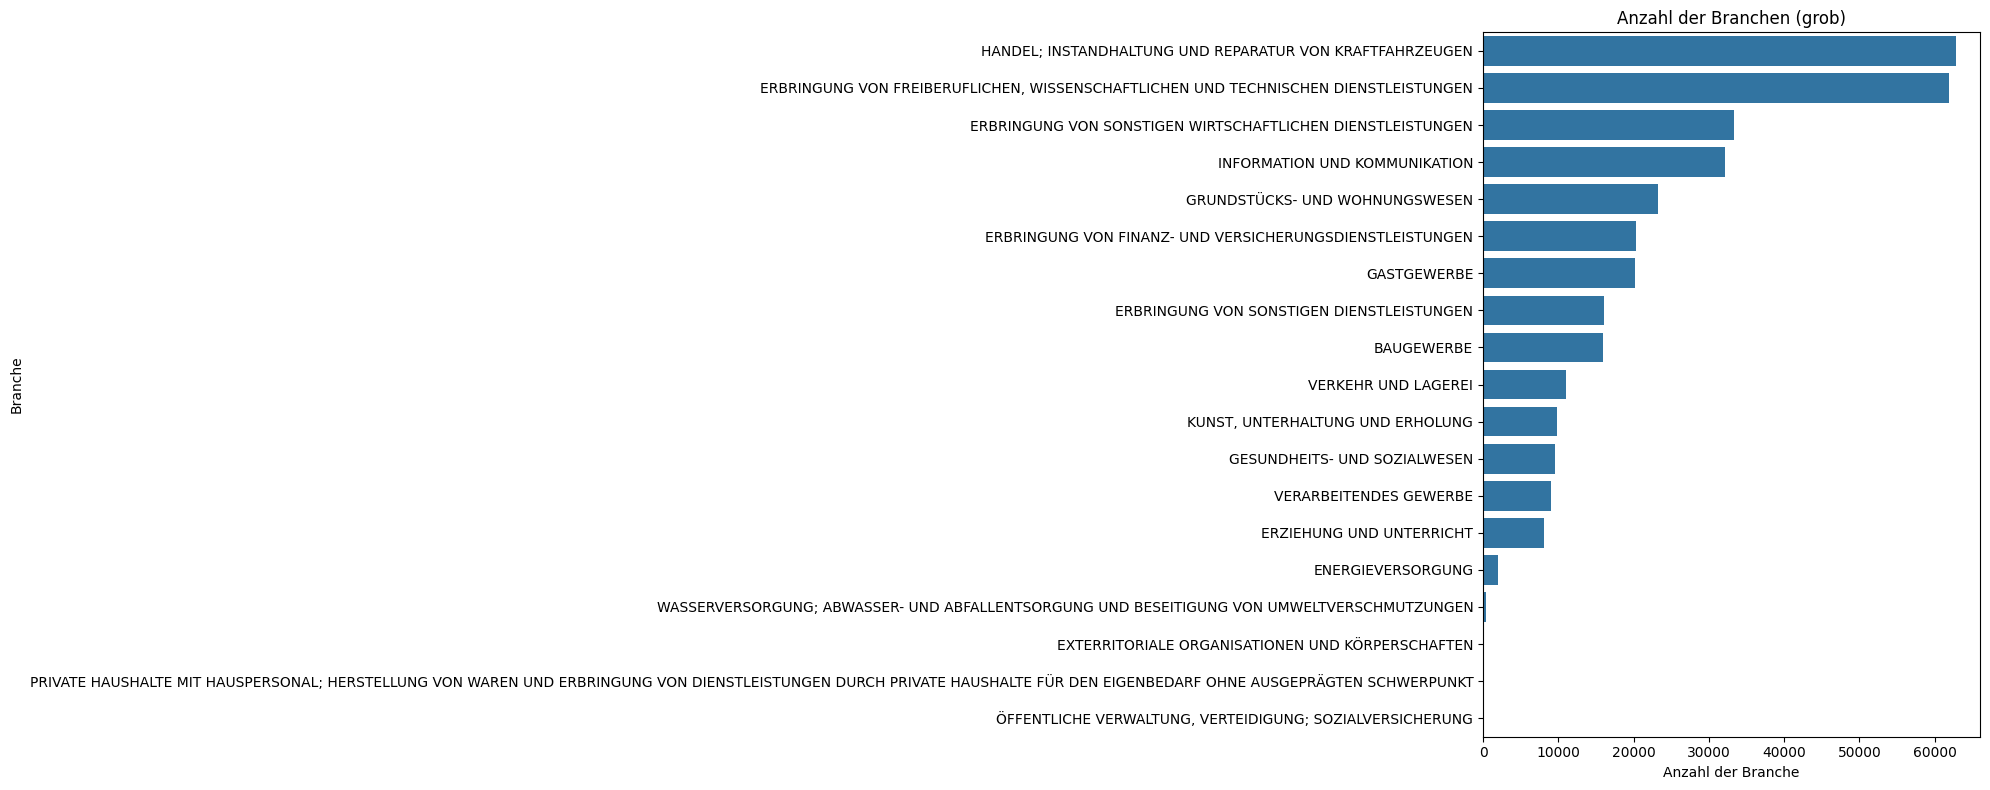

In [26]:
plt.figure(figsize=(20, 8))
sns.barplot(y=df["Branche_grob"].value_counts().index, x=df["Branche_grob"].value_counts().values)
plt.title("Anzahl der Branchen (grob)")
plt.ylabel("Branche")
plt.xlabel("Anzahl der Branche")
plt.tight_layout()
plt.show()

## Verteilung von business_age nach Bezirk und Branche_grob

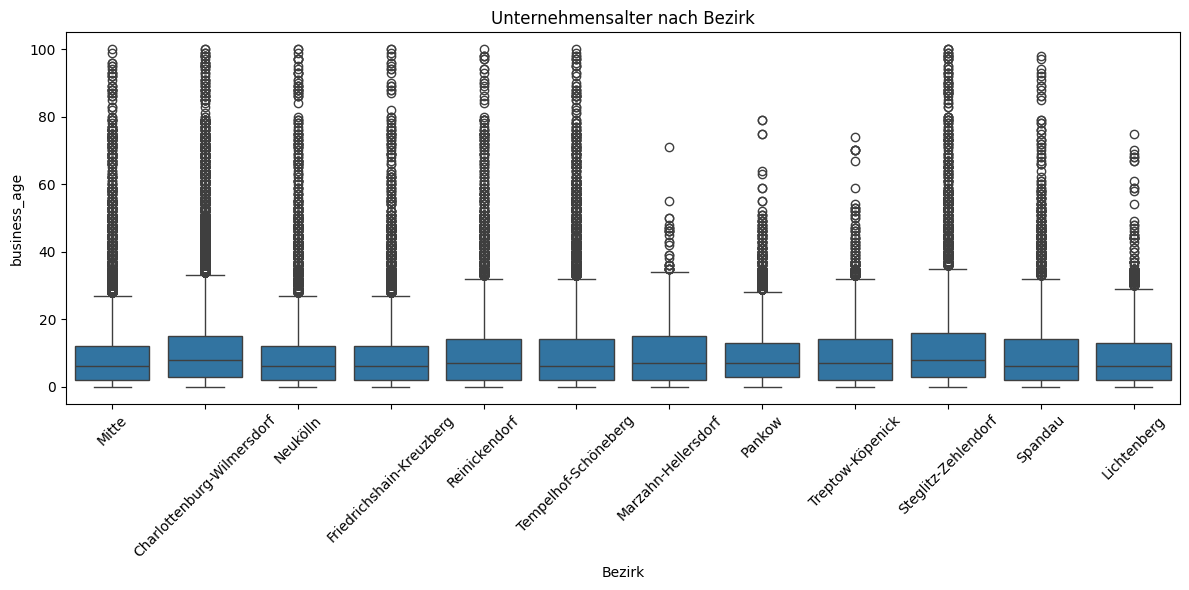

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Bezirk', y='business_age')
plt.xticks(rotation=45)
plt.title("Unternehmensalter nach Bezirk")
plt.tight_layout()
plt.show()

/var/folders/0c/r0htcd1j05v_lb53s4xtzbn80000gn/T/ipykernel_38761/82963100.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


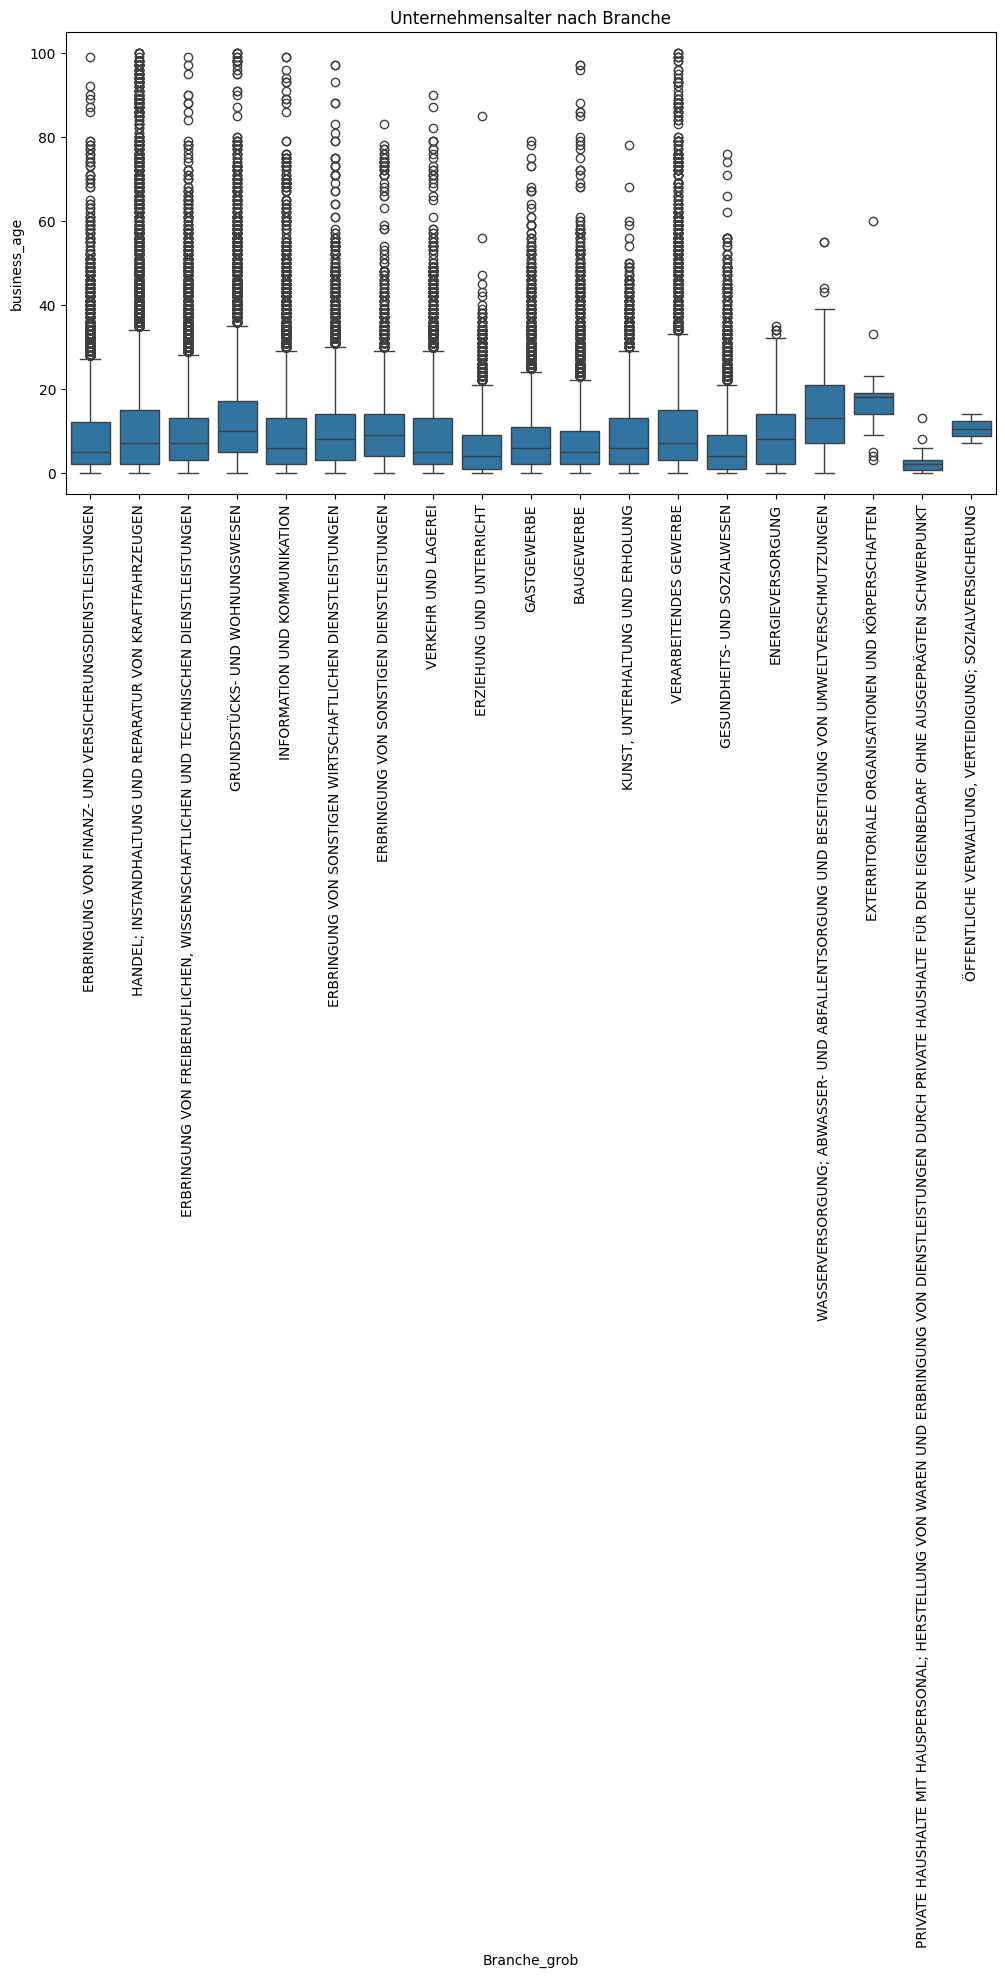

In [28]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Branche_grob', y='business_age')
plt.xticks(rotation=90)
plt.title("Unternehmensalter nach Branche")
plt.tight_layout()
plt.show()

## Beziehung: business_age vs. Bodenrichtwert, ew2023, ew_ha_2023

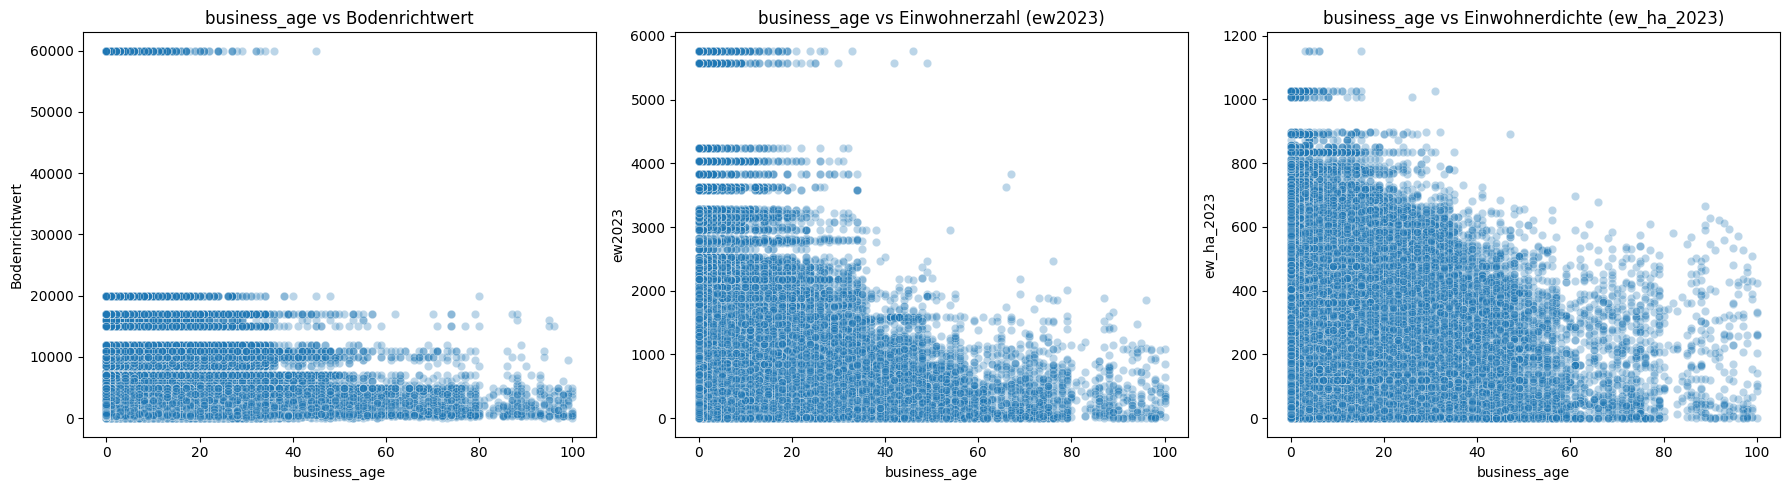

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x='business_age', y='Bodenrichtwert', alpha=0.3, ax=axes[0])
axes[0].set_title("business_age vs Bodenrichtwert")

sns.scatterplot(data=df, x='business_age', y='ew2023', alpha=0.3, ax=axes[1])
axes[1].set_title("business_age vs Einwohnerzahl (ew2023)")

sns.scatterplot(data=df, x='business_age', y='ew_ha_2023', alpha=0.3, ax=axes[2])
axes[2].set_title("business_age vs Einwohnerdichte (ew_ha_2023)")

plt.tight_layout()
plt.show()

Vermutung = ältere Unternehmen sind dort wo weniger Menschen sind und der BRW gering ist --> Wahrscheinlich mehr MA und brauchen mehr Platz (Grengebiete in Berlin)

## Heatmap: Mittelwerte gruppiert nach Bezirk und Branche_grob

/var/folders/0c/r0htcd1j05v_lb53s4xtzbn80000gn/T/ipykernel_38761/139937374.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


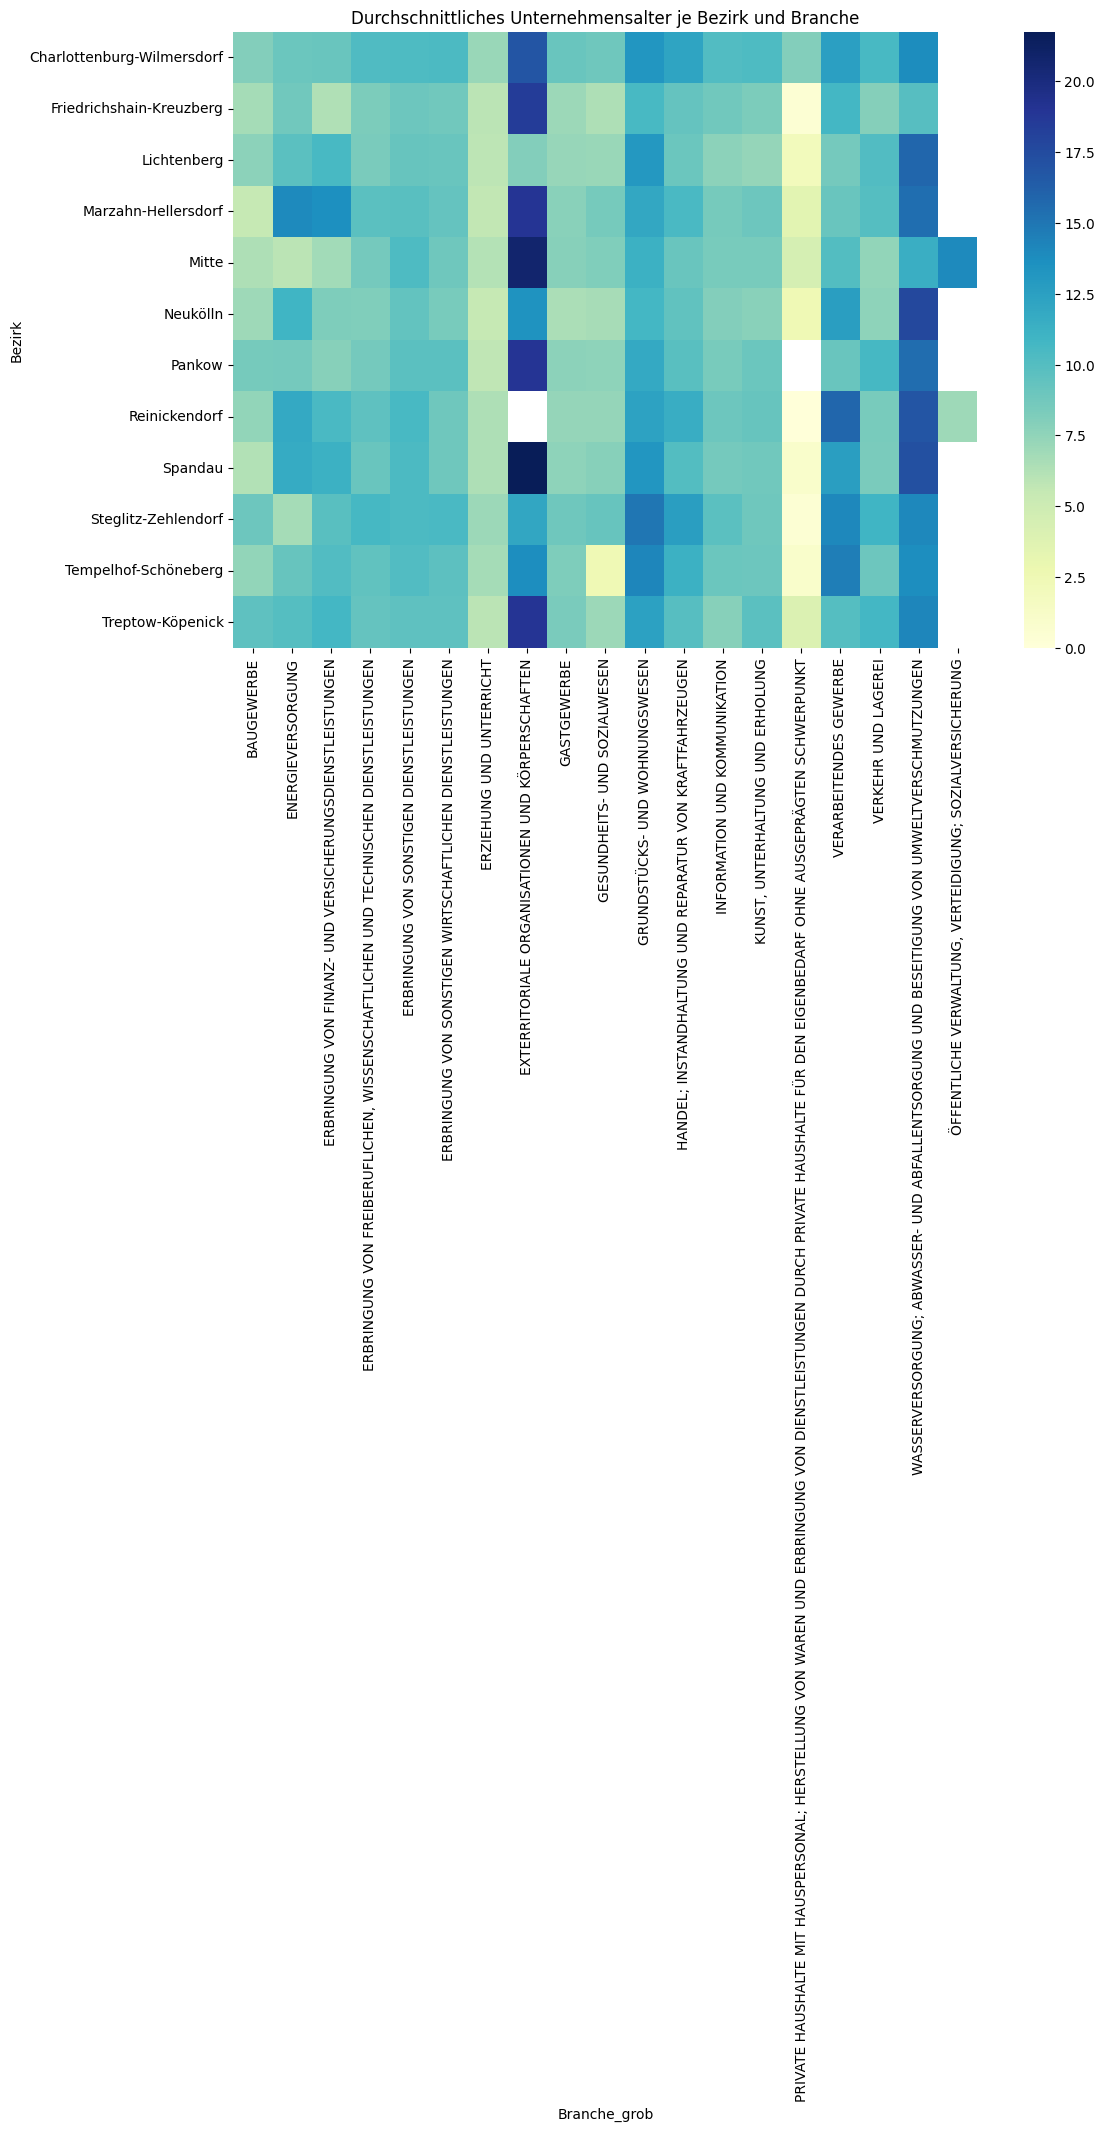

In [30]:
pivot = df.pivot_table(index='Bezirk', columns='Branche_grob', values='business_age', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=False, cmap='YlGnBu')
plt.title("Durchschnittliches Unternehmensalter je Bezirk und Branche")
plt.tight_layout()
plt.show()

## Pairplot (nur numerische Spalten)

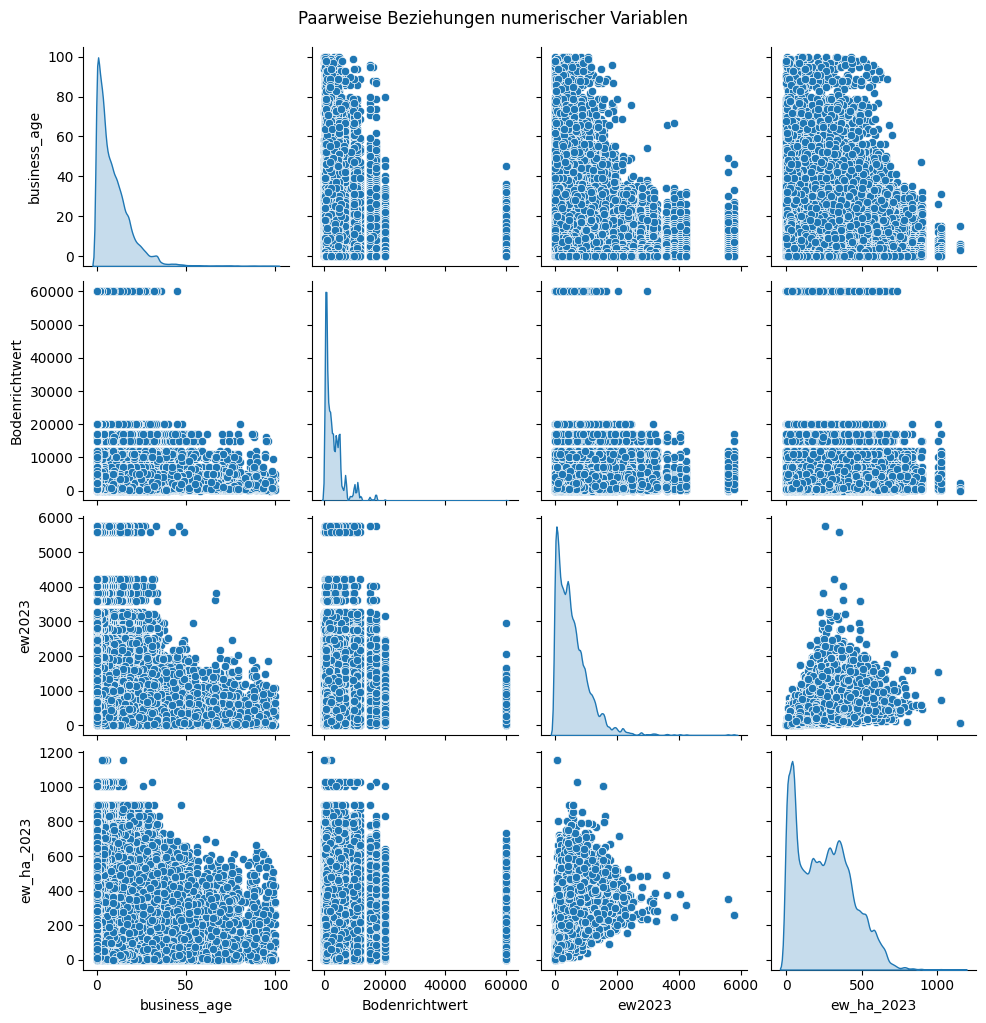

In [31]:
sns.pairplot(df[['business_age', 'Bodenrichtwert', 'ew2023', 'ew_ha_2023']], diag_kind='kde')
plt.suptitle("Paarweise Beziehungen numerischer Variablen", y=1.02)
plt.show()

## Korrelationstabelle der numerischen Werte

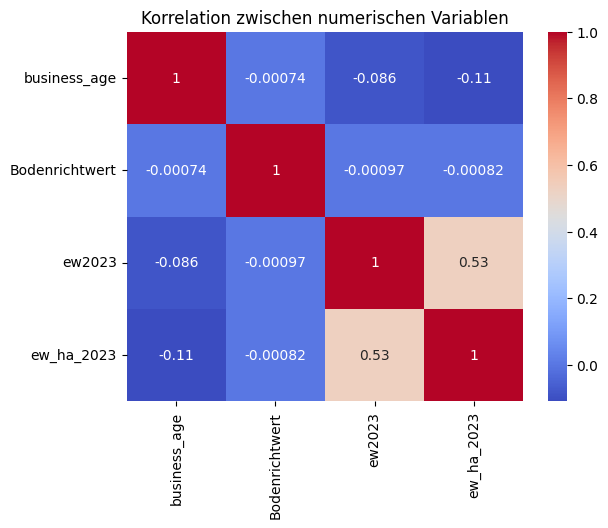

In [32]:
corr = df[['business_age', 'Bodenrichtwert', 'ew2023', 'ew_ha_2023']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korrelation zwischen numerischen Variablen")
plt.show()

## Altergruppen je Bezirk

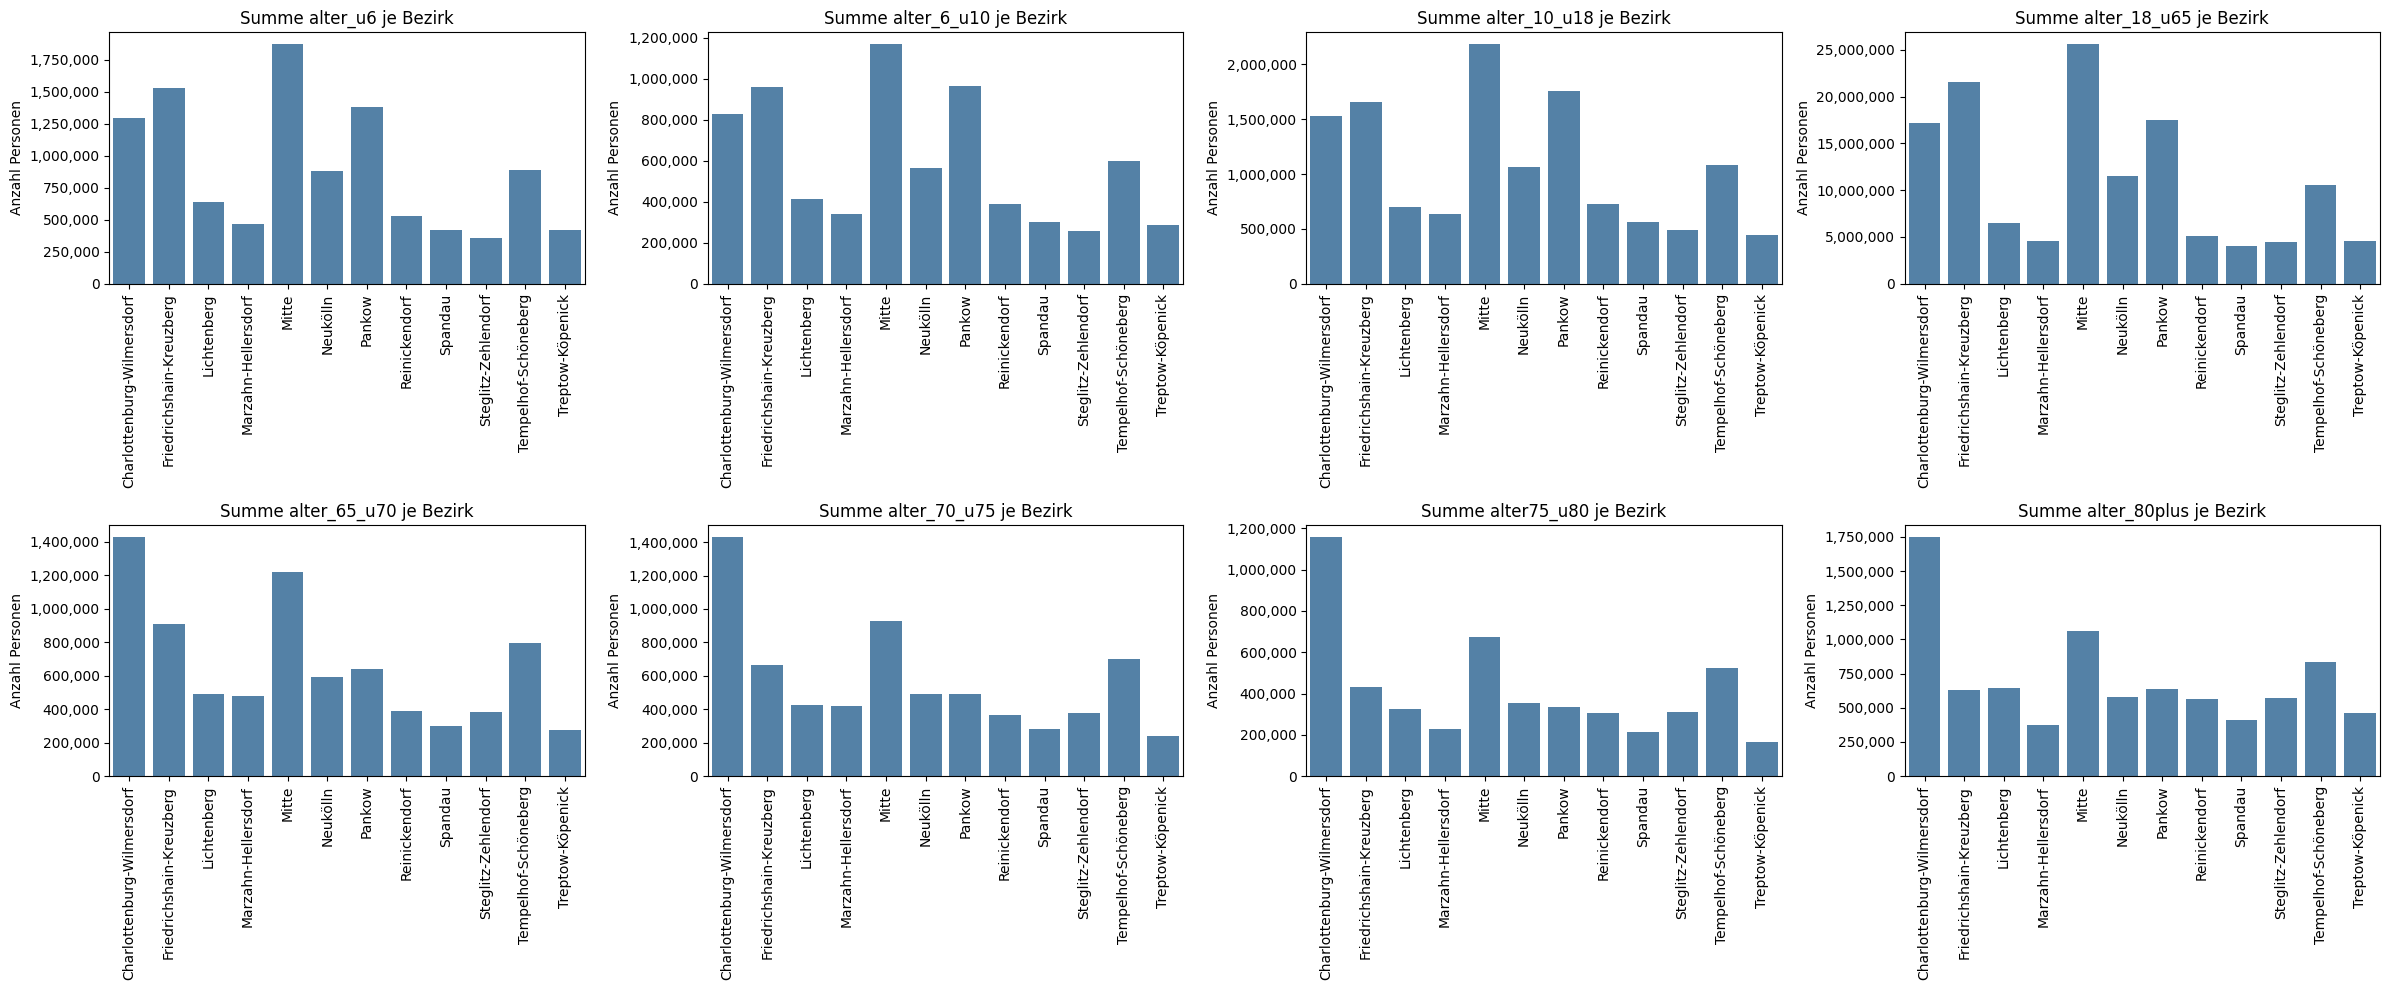

In [33]:
altersgruppen = [
    "alter_u6", "alter_6_u10", "alter_10_u18", "alter_18_u65",
    "alter_65_u70", "alter_70_u75", "alter75_u80", "alter_80plus"
]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 10))
axes = axes.flatten()

for i, col in enumerate(altersgruppen):
    sns.barplot(
        data=df.groupby("Bezirk")[altersgruppen].sum().reset_index(),
        x="Bezirk",
        y=col,
        ax=axes[i],
        color="steelblue"
    )
    axes[i].set_title(f"Summe {col} je Bezirk")
    axes[i].set_ylabel("Anzahl Personen")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.tight_layout()
plt.show()

# Data Preprocessing

- feartures = `Bodenrichtwert`, `business_age`, `ew2023`, `ew_ha_2023`, `Branche_grob`, `Bezirk`

In [34]:
features = df[["Bodenrichtwert", "business_age", "ew2023", "ew_ha_2023", "Branche_grob", "Bezirk"]]
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335962 entries, 0 to 336179
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Bodenrichtwert  335962 non-null  float64
 1   business_age    335962 non-null  float64
 2   ew2023          335962 non-null  float64
 3   ew_ha_2023      335962 non-null  float64
 4   Branche_grob    335962 non-null  object 
 5   Bezirk          335962 non-null  object 
dtypes: float64(4), object(2)
memory usage: 17.9+ MB


In [35]:
def iqr_outlier(df, column_name):
    col = df[column_name]
    
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    untere_grenze = Q1 - 1.5 * IQR
    obere_grenze = Q3 + 1.5 * IQR

    anzahl_unter = (col < untere_grenze).sum()
    anzahl_über = (col > obere_grenze).sum()

    print(f"Spalte: {column_name}")
    print(f"Q1 (25%): {Q1:.2f}")
    print(f"Q3 (75%): {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Untere Grenze (Ausreißer): {untere_grenze:.2f}")
    print(f"Obere Grenze (Ausreißer): {obere_grenze:.2f}")
    print(f"Anzahl unterhalb der unteren Grenze: {anzahl_unter}")
    print(f"Anzahl oberhalb der oberen Grenze: {anzahl_über}")

    return untere_grenze, obere_grenze

## Bodenrichtwert

In [36]:
# die 10 kleinsten Werte und deren Häufigkeit
features[features["Bodenrichtwert"].isin(features["Bodenrichtwert"].sort_values().unique()[:10])]["Bodenrichtwert"].value_counts().sort_index()

Bodenrichtwert
0.6      390
3.0        3
3.8       95
10.0     913
15.0     910
40.0     184
80.0      17
150.0     15
200.0    663
220.0    303
Name: count, dtype: int64

In [37]:
# die 10 größten Werte und deren Häufigkeit
features[features["Bodenrichtwert"].isin(features["Bodenrichtwert"].sort_values(ascending=False).unique()[:10])]["Bodenrichtwert"].value_counts().sort_index(ascending=False)

Bodenrichtwert
60000.0     204
20000.0     410
17000.0    2685
16000.0     502
15000.0    1468
12000.0    1913
11000.0    7446
10000.0    6365
9500.0     1546
9000.0     1077
Name: count, dtype: int64

## business_age

In [38]:
# die 10 kleinsten Werte und deren Häufigkeit
features[features["business_age"].isin(features["business_age"].sort_values().unique()[:10])]["business_age"].value_counts().sort_index()

business_age
0.0    32152
1.0    28302
2.0    25330
3.0    24173
4.0    21675
5.0    17416
6.0    15359
7.0    14488
8.0    14067
9.0    13109
Name: count, dtype: int64

In [39]:
# die 10 größten Werte und deren Häufigkeit
features[features["business_age"].isin(features["business_age"].sort_values(ascending=False).unique()[:10])]["business_age"].value_counts().sort_index(ascending=False)

business_age
100.0    12
99.0     10
98.0     17
97.0     15
96.0      9
95.0     15
94.0     11
93.0     18
92.0      8
91.0     10
Name: count, dtype: int64

## ew2023

In [40]:
# die 10 kleinsten Werte und deren Häufigkeit
features[features["ew2023"].isin(features["ew2023"].sort_values().unique()[:10])]["ew2023"].value_counts().sort_index()

ew2023
0.0     2707
3.0     5952
4.0      335
5.0        1
6.0     3319
7.0      650
8.0       15
9.0     2413
10.0     525
11.0     107
Name: count, dtype: int64

In [41]:
# die 10 größten Werte und deren Häufigkeit
features[features["ew2023"].isin(features["ew2023"].sort_values(ascending=False).unique()[:10])]["ew2023"].value_counts().sort_index(ascending=False)

ew2023
5766.0    131
5578.0    130
4241.0     96
4033.0    143
3837.0    105
3627.0    168
3587.0     77
3280.0    106
3261.0     79
3216.0     76
Name: count, dtype: int64

## ew_ha_2023

In [42]:
# die 10 kleinsten Werte und deren Häufigkeit
features[features["ew_ha_2023"].isin(features["ew_ha_2023"].sort_values().unique()[:10])]["ew_ha_2023"].value_counts().sort_index()

ew_ha_2023
0.00    2707
0.07      47
0.08     155
0.09      27
0.12     150
0.13       2
0.14       8
0.16      98
0.17     227
0.19       4
Name: count, dtype: int64

In [43]:
# die 10 größten Werte und deren Häufigkeit
features[features["ew2023"].isin(features["ew2023"].sort_values(ascending=False).unique()[:10])]["ew2023"].value_counts().sort_index(ascending=False)

ew2023
5766.0    131
5578.0    130
4241.0     96
4033.0    143
3837.0    105
3627.0    168
3587.0     77
3280.0    106
3261.0     79
3216.0     76
Name: count, dtype: int64

# Clustering

## Zentroiden basiert: Kmeans

In [44]:
numerische_spalten = ["Bodenrichtwert", "business_age", "ew2023", "ew_ha_2023"]
filtered_df = features.copy()

for spalte in numerische_spalten:
    untere_grenze, obere_grenze = iqr_outlier(filtered_df, spalte)
    filtered_df = filtered_df[(filtered_df[spalte] >= untere_grenze) & (filtered_df[spalte] <= obere_grenze)]

features_kmeans = filtered_df.reset_index(drop=True)
features_kmeans.info()

Spalte: Bodenrichtwert
Q1 (25%): 700.00
Q3 (75%): 4500.00
IQR: 3800.00
Untere Grenze (Ausreißer): -5000.00
Obere Grenze (Ausreißer): 10200.00
Anzahl unterhalb der unteren Grenze: 0
Anzahl oberhalb der oberen Grenze: 14628
Spalte: business_age
Q1 (25%): 2.00
Q3 (75%): 14.00
IQR: 12.00
Untere Grenze (Ausreißer): -16.00
Obere Grenze (Ausreißer): 32.00
Anzahl unterhalb der unteren Grenze: 0
Anzahl oberhalb der oberen Grenze: 9086
Spalte: ew2023
Q1 (25%): 181.00
Q3 (75%): 819.00
IQR: 638.00
Untere Grenze (Ausreißer): -776.00
Obere Grenze (Ausreißer): 1776.00
Anzahl unterhalb der unteren Grenze: 0
Anzahl oberhalb der oberen Grenze: 9299
Spalte: ew_ha_2023
Q1 (25%): 78.16
Q3 (75%): 377.01
IQR: 298.85
Untere Grenze (Ausreißer): -370.12
Obere Grenze (Ausreißer): 825.29
Anzahl unterhalb der unteren Grenze: 0
Anzahl oberhalb der oberen Grenze: 461
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302488 entries, 0 to 302487
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dty

In [45]:
# One Hot Encoding
features_kmeans = pd.get_dummies(features_kmeans, columns=["Branche_grob", "Bezirk"], drop_first=False)
features_kmeans.head()

,Bodenrichtwert,business_age,ew2023,ew_ha_2023,Branche_grob_BAUGEWERBE,Branche_grob_ENERGIEVERSORGUNG,Branche_grob_ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEISTUNGEN,"Branche_grob_ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN",Branche_grob_ERBRINGUNG VON SONSTIGEN DIENSTLEISTUNGEN,Branche_grob_ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN,...,Bezirk_Lichtenberg,Bezirk_Marzahn-Hellersdorf,Bezirk_Mitte,Bezirk_Neukölln,Bezirk_Pankow,Bezirk_Reinickendorf,Bezirk_Spandau,Bezirk_Steglitz-Zehlendorf,Bezirk_Tempelhof-Schöneberg,Bezirk_Treptow-Köpenick
0,650.0,13.0,254.0,666.12,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1,900.0,10.0,49.0,101.53,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,8500.0,15.0,716.0,389.62,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1400.0,10.0,726.0,308.85,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,10000.0,9.0,90.0,31.12,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [46]:
# Standardisierung ohne Veränderung von features_kmeans
scaler = StandardScaler()
features_kmeans_scaled = scaler.fit_transform(features_kmeans)

# Rückumwandeln in DataFrame mit gleichen Spaltennamen
features_kmeans_scaled = pd.DataFrame(features_kmeans_scaled, columns=features_kmeans.columns)

# Optional: Ausgabe zum Prüfen
features_kmeans_scaled.head()

,Bodenrichtwert,business_age,ew2023,ew_ha_2023,Branche_grob_BAUGEWERBE,Branche_grob_ENERGIEVERSORGUNG,Branche_grob_ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEISTUNGEN,"Branche_grob_ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN",Branche_grob_ERBRINGUNG VON SONSTIGEN DIENSTLEISTUNGEN,Branche_grob_ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN,...,Bezirk_Lichtenberg,Bezirk_Marzahn-Hellersdorf,Bezirk_Mitte,Bezirk_Neukölln,Bezirk_Pankow,Bezirk_Reinickendorf,Bezirk_Spandau,Bezirk_Steglitz-Zehlendorf,Bezirk_Tempelhof-Schöneberg,Bezirk_Treptow-Köpenick
0,-0.860334,0.611544,-0.643343,2.320531,-0.222912,-0.08028,-0.254114,2.089366,-0.225425,-0.332955,...,-0.210443,-0.191356,-0.432516,3.475629,-0.351005,-0.236674,-0.209138,-0.28386,-0.33526,-0.241066
1,-0.748744,0.209168,-1.142732,-0.804604,-0.222912,-0.08028,-0.254114,-0.478614,-0.225425,-0.332955,...,-0.210443,-0.191356,2.312054,-0.287718,-0.351005,-0.236674,-0.209138,-0.28386,-0.33526,-0.241066
2,2.643598,0.879794,0.482109,0.790040,-0.222912,-0.08028,-0.254114,2.089366,-0.225425,-0.332955,...,-0.210443,-0.191356,-0.432516,-0.287718,2.848961,-0.236674,-0.209138,-0.28386,-0.33526,-0.241066
3,-0.525564,0.209168,0.506469,0.342959,-0.222912,-0.08028,-0.254114,2.089366,-0.225425,-0.332955,...,-0.210443,-0.191356,-0.432516,-0.287718,2.848961,-0.236674,-0.209138,-0.28386,-0.33526,-0.241066
4,3.313139,0.075043,-1.042854,-1.194340,-0.222912,-0.08028,-0.254114,-0.478614,-0.225425,-0.332955,...,-0.210443,-0.191356,-0.432516,-0.287718,-0.351005,-0.236674,-0.209138,-0.28386,-0.33526,4.148242


In [47]:
print(features_kmeans.isnull().sum())              # NaNs?
print(np.isinf(features_kmeans).sum().sum())       # unendliche Werte?
print(np.isnan(features_kmeans).sum().sum())       # Not-a-Number?

# Optional: Statistische Übersicht
features_kmeans.describe()

Bodenrichtwert                                                                                                                                                                          0
business_age                                                                                                                                                                            0
ew2023                                                                                                                                                                                  0
ew_ha_2023                                                                                                                                                                              0
Branche_grob_BAUGEWERBE                                                                                                                                                                 0
Branche_grob_ENERGIEVERSORGUNG                                        

,Bodenrichtwert,business_age,ew2023,ew_ha_2023
count,302488.000000,302488.000000,302488.000000,302488.000000
mean,2577.441429,8.440500,518.093432,246.890610
std,2240.343643,7.455736,410.502475,180.661302
min,0.600000,0.000000,0.000000,0.000000
25%,670.000000,2.000000,172.000000,77.820000
50%,1900.000000,6.000000,437.000000,235.280000
75%,4000.000000,13.000000,779.000000,376.152500
max,10000.000000,32.000000,1773.000000,813.430000


/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/clus

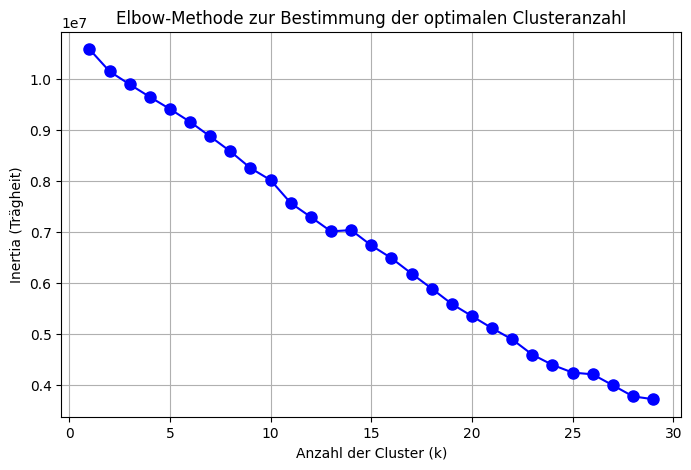

In [48]:
# Elbow-Methode: Inertia für K=1 bis K=30 berechnen
inertia = []
k_range = range(1, 30)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# Plot der Elbow-Kurve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia (Trägheit)')
plt.title('Elbow-Methode zur Bestimmung der optimalen Clusteranzahl')
plt.grid(True)
plt.show()

KMeans führt zu keinem guten Ergebnis

## weiches Clustering: GMM

In [49]:
def iqr_outlier(df, spalte):
    q1 = df[spalte].quantile(0.25)
    q3 = df[spalte].quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

# === Datenvorbereitung ===
numerische_spalten = ["Bodenrichtwert", "business_age", "ew2023", "ew_ha_2023"]
filtered_df = features.copy()

for spalte in numerische_spalten:
    lower, upper = iqr_outlier(filtered_df, spalte)
    filtered_df = filtered_df[(filtered_df[spalte] >= lower) & (filtered_df[spalte] <= upper)]

# One-Hot-Encoding
features_gmm = pd.get_dummies(filtered_df.reset_index(drop=True), columns=["Branche_grob", "Bezirk"])

# Standardisierung
scaler = StandardScaler()
features_gmm_scaled = scaler.fit_transform(features_gmm)

In [50]:
# === Modelltraining mit GMM ===
# Du kannst n_components später per BIC/AIC bestimmen
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(features_gmm_scaled)

# Clusterlabels anhängen
features_gmm['Cluster'] = gmm_labels

# Ausgabe der Clusterverteilung
print(features_gmm['Cluster'].value_counts())

/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/clus

Cluster
4    97342
2    82912
1    51180
3    48334
0    22720
Name: count, dtype: int64


In [51]:
# === Optional: Wahrscheinlichkeiten anzeigen (soft clustering)
probs = gmm.predict_proba(features_gmm_scaled)
print(probs[:5])  # erste 5 Zeilen

[[0.00000000e+000 0.00000000e+000 3.37753977e-019 0.00000000e+000
  1.00000000e+000]
 [2.43934333e-220 0.00000000e+000 9.21562117e-023 1.00000000e+000
  0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.50119040e-018 0.00000000e+000
  1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.56598601e-018 0.00000000e+000
  1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.65623243e-035 2.03253974e-010
  1.00000000e+000]]


/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/antonioaleksic/Documents/DAMI01/.venv/lib/python3.13/site-packages/skl

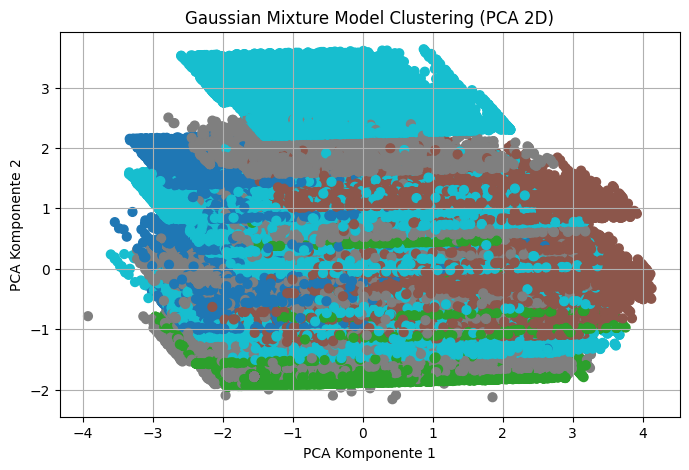

In [52]:
# === Visualisierung per PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(features_gmm_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(reduced[:, 0], reduced[:, 1], c=gmm_labels, cmap='tab10', s=40)
plt.title("Gaussian Mixture Model Clustering (PCA 2D)")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.grid(True)
plt.show()

In [53]:
features_gmm.groupby("Cluster")[numerische_spalten].mean()

,Bodenrichtwert,business_age,ew2023,ew_ha_2023
Cluster,,,,
0,2572.443653,9.328521,288.538248,128.435034
1,2568.814048,8.814830,530.425869,247.886269
2,2581.456508,7.918516,628.626628,299.998877
3,2566.530471,7.388857,480.302768,225.427639
4,2585.141813,9.003205,489.805182,239.436802


In [54]:
# Clusterlabels an den Original-Datensatz anhängen
filtered_df = filtered_df.reset_index(drop=True)  # sicherstellen, dass Index passt
filtered_df["Cluster"] = features_gmm["Cluster"].values

# Häufigste 3 Branchen je Cluster ermitteln
top3_branchen = (
    filtered_df.groupby("Cluster")["Branche_grob"]
    .value_counts()
    .groupby(level=0)
    .nlargest(3)
)

print(top3_branchen)

Cluster  Cluster  Branche_grob                                                                       
0        0        ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN     4499
                  HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFTFAHRZEUGEN                                4134
                  ERBRINGUNG VON SONSTIGEN WIRTSCHAFTLICHEN DIENSTLEISTUNGEN                              2330
1        1        HANDEL; INSTANDHALTUNG UND REPARATUR VON KRAFTFAHRZEUGEN                               51180
2        2        INFORMATION UND KOMMUNIKATION                                                          27295
                  GASTGEWERBE                                                                            17568
                  ERBRINGUNG VON FREIBERUFLICHEN, WISSENSCHAFTLICHEN UND TECHNISCHEN DIENSTLEISTUNGEN    16183
3        3        ERBRINGUNG VON FINANZ- UND VERSICHERUNGSDIENSTLEISTUNGEN                               15084
          

## Dichten basiert: DBSCAN

In [ ]:
def iqr_outlier(df, spalte):
    q1 = df[spalte].quantile(0.25)
    q3 = df[spalte].quantile(0.75)
    iqr = q3 - q1
    untere_grenze = q1 - 1.5 * iqr
    obere_grenze = q3 + 1.5 * iqr
    return untere_grenze, obere_grenze

# === Datenvorbereitung ===
numerische_spalten = ["Bodenrichtwert", "business_age", "ew2023", "ew_ha_2023"]
filtered_df = features.copy()

# IQR-basiertes Outlier-Filtering
for spalte in numerische_spalten:
    untere_grenze, obere_grenze = iqr_outlier(filtered_df, spalte)
    filtered_df = filtered_df[(filtered_df[spalte] >= untere_grenze) & (filtered_df[spalte] <= obere_grenze)]

# Index zurücksetzen
features_dbscan = filtered_df.reset_index(drop=True)

# One-Hot-Encoding
features_dbscan = pd.get_dummies(features_dbscan, columns=["Branche_grob", "Bezirk"], drop_first=False)

# Standardisierung
scaler = StandardScaler()
features_dbscan_scaled = scaler.fit_transform(features_dbscan)

# === DBSCAN anwenden ===
# Achtung: eps und min_samples müssen angepasst werden je nach Datensatz
dbscan_model = DBSCAN(eps=1.5, min_samples=5)  # eps ggf. per Grid oder k-Dist-Plot optimieren
cluster_labels = dbscan_model.fit_predict(features_dbscan_scaled)

# Cluster-Ergebnisse anhängen
features_dbscan["Cluster"] = cluster_labels

# Cluster-Zusammenfassung
print(features_dbscan["Cluster"].value_counts())
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Anzahl der gefundenen Cluster (ohne Rauschen): {n_clusters}")
print(f"Anzahl an Rauschen (Cluster = -1): {(cluster_labels == -1).sum()}")

In [ ]:
# === Visualisierung mit PCA (2D) ===
pca = PCA(n_components=2)
reduced = pca.fit_transform(features_dbscan_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_labels, cmap='tab10', s=40)
plt.title("DBSCAN Clustering (PCA-Reduktion auf 2D)")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.grid(True)
plt.show()
